In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

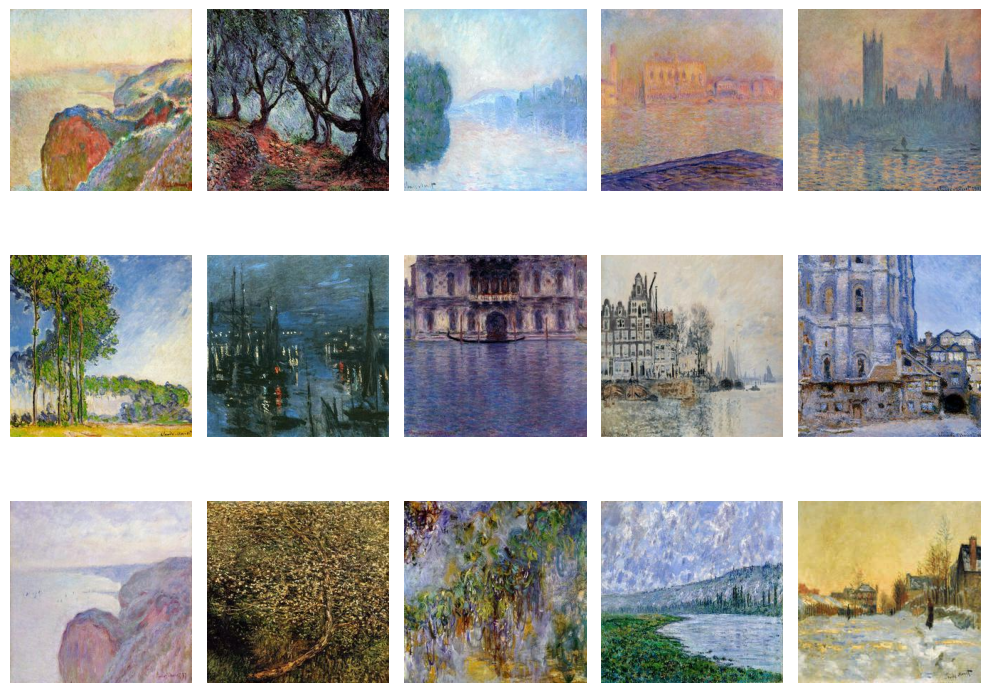

In [3]:
dir = "data/monet_jpg"
fig, axes = plt.subplots(3, 5, figsize = (10, 8))
ax = axes.flatten()

for i, file in zip(range(15), os.listdir(dir)):
    image = Image.open(os.path.join(dir, file))
    ax[i].imshow(transforms.ToTensor()(image).movedim(0, -1))
    ax[i].axis("off")
    
plt.axis("off")
plt.tight_layout()

In [4]:
from torch.utils.data import DataLoader, Dataset

class PaintingDataset(Dataset):
    def __init__(self, dir, transform = None):
        self.transform = transform
        self.root = dir
        self.paths = os.listdir(dir)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root, self.paths[idx])).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
dataset = DataLoader(PaintingDataset(dir, transforms.ToTensor()), batch_size = 32, shuffle = True)

In [6]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.style = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
        )
        self.generator = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1024, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(True)
        )
        self.generator2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(3),
            torch.nn.Tanh()
        )
         
    def forward(self, x):
        x = self.style(x)
        x = self.generator(x)
        x = self.generator2(x)
        return x

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(0.1, True),
            torch.nn.Conv2d(16, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.1, True),
            torch.nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(32*32*64, 512),
            torch.nn.LeakyReLU(0.1, True),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.1, True),
            torch.nn.Linear(256, 1),
        )
    def forward(self, x):
        x = self.discriminator(x)
        x = torch.flatten(x, 1, -1)
        x = self.fc(x)
        return x.squeeze()

In [8]:
gen = Generator().to(device)
discrim = Discriminator().to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer_discrim = torch.optim.NAdam(discrim.parameters(), lr = 0.00001)
optimizer_gen = torch.optim.NAdam(gen.parameters(), lr = 0.0002)

In [9]:
def train(dataloader, generator, discriminator, loss_fn, optimizer_discrim, optimizer_gen, device, epoch, function = None):
    size = len(dataloader.dataset) * 2
    generator.train()
    discriminator.train()
    train_correct = 0
    for batch, x  in enumerate(dataloader):
        discriminator.zero_grad()
        x = x.to(device)
        labels = torch.full((x.size(0),), 1, dtype = torch.float, device = device)
        pred = discriminator(x)
        real_loss = loss_fn(pred, labels)
        real_loss.backward()
        
        train_correct += ((pred > 0.5) == labels).type(torch.float).sum().item()
        
        fake_imgs = generator(x).to(device)
        labels.fill_(0)
        pred = discriminator((fake_imgs).detach())
        fake_loss = loss_fn(pred, labels)
        discrim_loss = real_loss + fake_loss
        fake_loss.backward()
        optimizer_discrim.step()
        
        train_correct += ((pred > 0.5) == labels).type(torch.float).sum().item()
        
        generator.zero_grad()
        labels.fill_(1)
        pred = discriminator(fake_imgs)
        gen_loss = loss_fn(pred, labels)
        gen_loss.backward()
        optimizer_gen.step()
        if (epoch+1) % 100 == 0:
            if (batch % 100 == 0):
                gen_loss, discrim_loss, current = gen_loss.item(), (discrim_loss).item(), (batch + 1) * len(x)
                
                print(f"Generator Loss: {gen_loss:>5f}\nDiscriminator Loss: {discrim_loss:>5f}  [{current:>3d}/{size:>3d}]")
                n_cols = 8
                n_rows = 4
                plt.figure(figsize = (n_cols, n_rows))
                for index, image in enumerate((fake_imgs).cpu().detach().numpy()):
                    plt.subplot(n_rows, n_cols, index + 1)
                    plt.imshow(image.transpose(1, 2, 0))
                    plt.axis("off")
                plt.show()

Epoch 100
-------------------------------
Generator Loss: 0.860276
Discriminator Loss: 1.206596  [ 32/600]


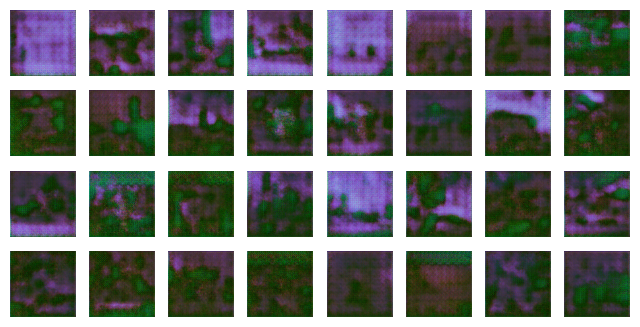

Epoch 200
-------------------------------
Generator Loss: 2.290558
Discriminator Loss: 0.342035  [ 32/600]


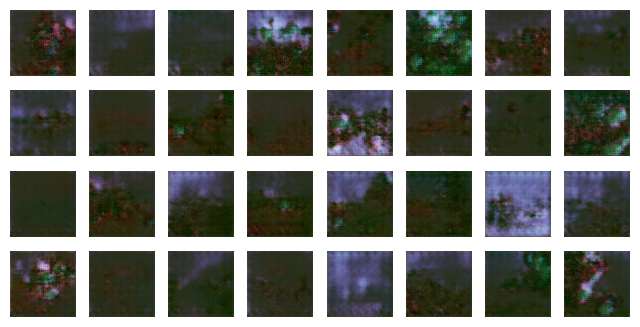

Epoch 300
-------------------------------
Generator Loss: 2.565272
Discriminator Loss: 0.343365  [ 32/600]


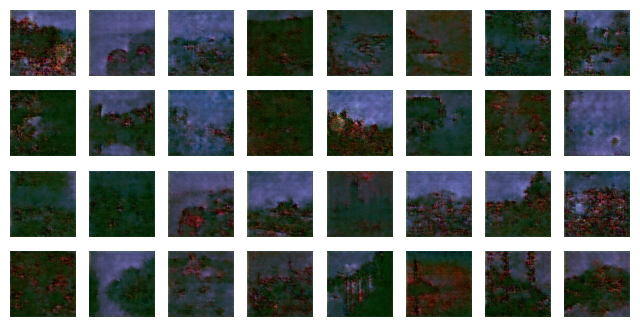

Epoch 400
-------------------------------
Generator Loss: 3.957453
Discriminator Loss: 0.340732  [ 32/600]


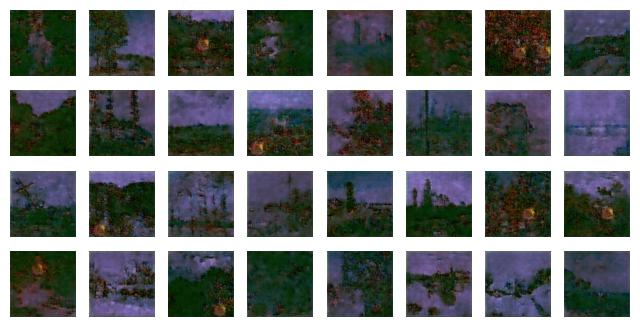

Epoch 500
-------------------------------
Generator Loss: 3.718706
Discriminator Loss: 0.242161  [ 32/600]


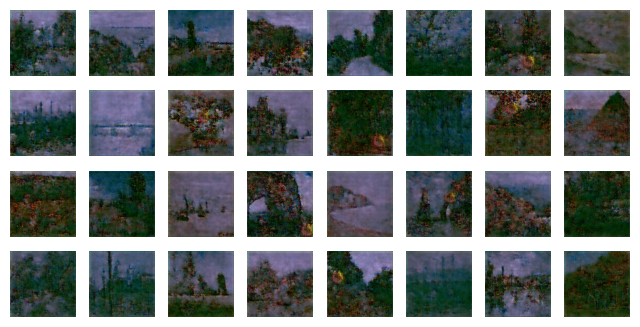

Epoch 600
-------------------------------
Generator Loss: 4.864328
Discriminator Loss: 0.153291  [ 32/600]


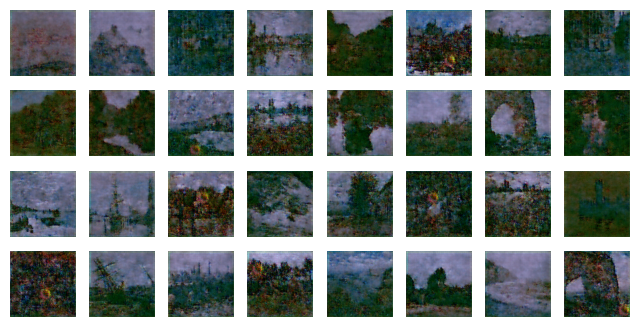

Epoch 700
-------------------------------
Generator Loss: 5.604097
Discriminator Loss: 0.102658  [ 32/600]


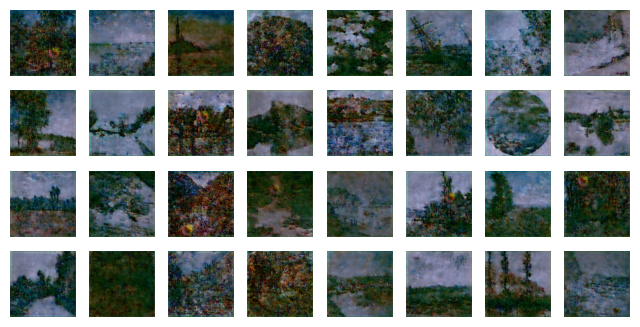

Epoch 800
-------------------------------
Generator Loss: 7.527746
Discriminator Loss: 0.088960  [ 32/600]


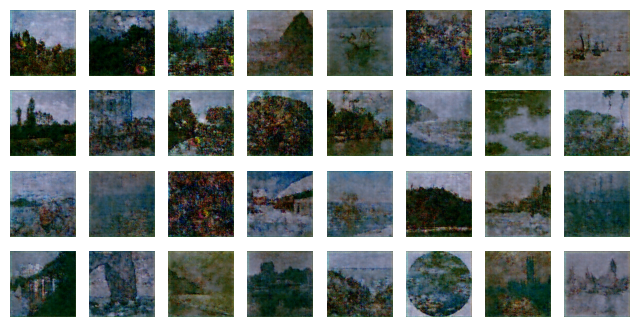

Epoch 900
-------------------------------
Generator Loss: 5.043355
Discriminator Loss: 1.002688  [ 32/600]


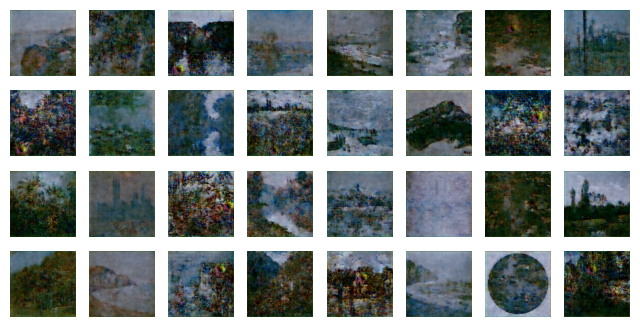

Epoch 1000
-------------------------------
Generator Loss: 5.523551
Discriminator Loss: 0.151996  [ 32/600]


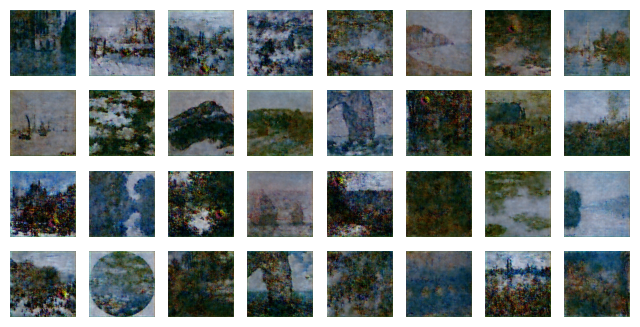

In [10]:
epochs = 1000
for epoch in range(epochs):
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}\n-------------------------------")
    train(dataset, gen, discrim, loss_fn, optimizer_discrim, optimizer_gen, device, epoch)

In [27]:
def apply_style(image_dir, generator, device):
    fig, axes = plt.subplots(6, 5, figsize = (10, 8))
    ax = axes.flatten()
    for i, file in zip(range(15), os.listdir(image_dir)):
        image = Image.open(os.path.join(image_dir, file))
        ax[i].imshow(image)
        ax[i].axis("off")
        image = transforms.ToTensor()(image)
        image = image.unsqueeze(0).to(device)
        image = generator(image).squeeze(0).movedim(0, -1)
        ax[i+15].imshow((image).cpu().detach().numpy())
        ax[i+15].axis("off")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

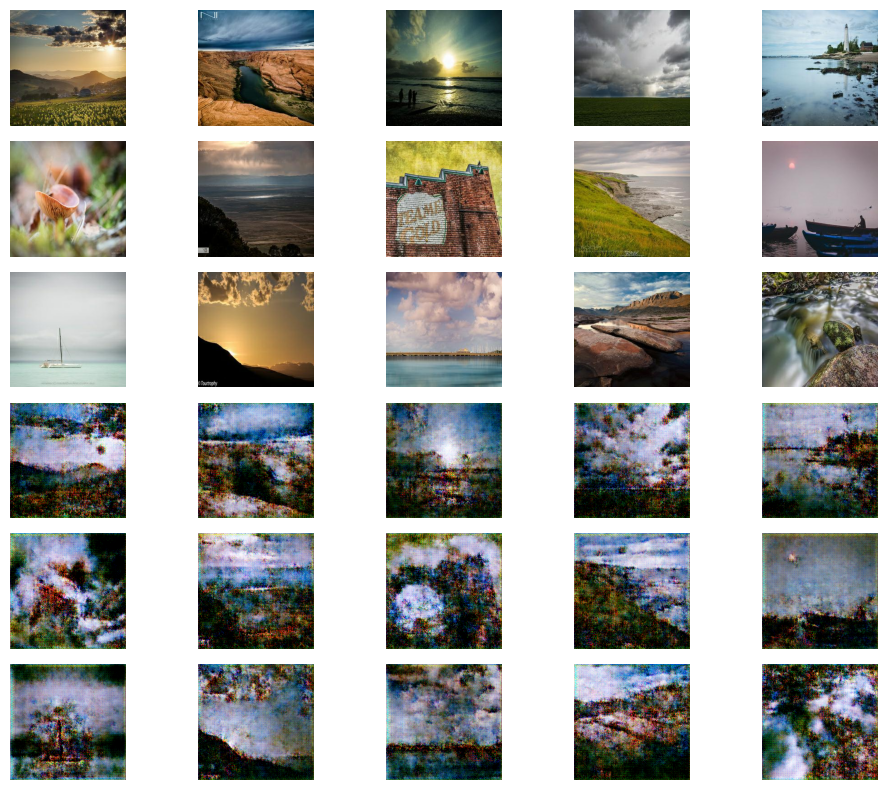

In [28]:
apply_style(r"data\photo_jpg", gen, device)